<a href="https://colab.research.google.com/github/tayyab5838/langgraph_projects/blob/main/customer_support_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an Intelligent Customer Support Agent with LangGraph

### Motivation
In today's fast-paced business environment, efficient and accurate customer support is crucial. Automating the initial stages of customer interaction can significantly reduce response times and improve overall customer satisfaction. This project aims to showcase how advanced language models and graph-based workflows can be combined to create a sophisticated support system that can handle a variety of customer inquiries.

### Key Components
1. State Management: Using TypedDict to define and manage the state of each customer interaction.
2. Query Categorization: Classifying customer queries into Technical, Billing, or General categories.
3. Sentiment Analysis: Determining the emotional tone of customer queries.
4. Response Generation: Creating appropriate responses based on the query category and sentiment.
5. Escalation Mechanism: Automatically escalating queries with negative sentiment to human agents.
6. Workflow Graph: Utilizing LangGraph to create a flexible and extensible workflow.
### Method Details
1. Initialization: Set up the environment and import necessary libraries.
2. State Definition: Create a structure to hold query information, category, sentiment, and response.
3. Node Functions: Implement separate functions for categorization, sentiment analysis, and response generation.
4. Graph Construction: Use StateGraph to define the workflow, adding nodes and edges to represent the support process.
5. Conditional Routing: Implement logic to route queries based on their category and sentiment.
6. Workflow Compilation: Compile the graph into an executable application.
7. Execution: Process customer queries through the workflow and retrieve results.

In [2]:
%%capture --no-stderr
%pip install --q -U langchain_core langchain_google_genai langgraph

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image


In [4]:
from google.colab import userdata
import os
os.environ["GEMINI_API_KEY"] = userdata.get('GEMNI_API_KEY')

### Define State Structure

In [5]:
class State(TypedDict):
  query: str
  category: str
  sentiment: str
  response: str

### Define Node Functions

In [6]:
def categorize(state: State)-> State:
  """Categorize the customer query into Technical, Billing, or General."""
  prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
  )
  chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
  category = chain.invoke({"query": state["query"]})
  return {"category": category}

def analyze_sentiment(state: State)-> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
    sentiment = chain.invoke({"query": state["query"]})
    return {"sentiment": sentiment}

def handle_technical_queries(state: State)-> State:
    """Handle queries related to technical issues."""
    prompt = ChatPromptTemplate.from_template(
    "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
    response = chain.invoke({"query": state["query"]})
    return {"response": response}

def handle_billing_queries(state: State)-> State:
   """Provide a billing support response to the query."""
   prompt = ChatPromptTemplate.from_template(
       "Provide a billing support response to the following query: {query}"
   )
   chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
   response = chain.invoke({"query": state["query"]})
   return {"response": response}

def handle_general_queries(state: State)-> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=os.environ["GEMINI_API_KEY"])
    response = chain.invoke({"query": state["query"]})
    return {"response": response}

def escalate_to_human(state: State)-> State:
    """Escalate the query to a human agent if the sentiment is negative."""
    return {"response": "Query has been escalated to a human agent due to negative sentiments."}

def rout_query(state: State)-> str:
    """Route the query based on its category and sentiment."""
    if state["sentiment"] == "Negative":
        return "escalate_to_human"
    elif state["category"] == "Technical":
        return "handle_technical_queries"
    elif state["category"] == "Billing":
        return "handle_billing_queries"
    else:
        return "handle_general_queries"

### Create and Configure the Graph


In [7]:
builder: StateGraph = StateGraph(State)

builder.add_node("categorize", categorize)
builder.add_node("analyze_sentiment", analyze_sentiment)
builder.add_node("handle_technical", handle_technical_queries)
builder.add_node("handle_billing", handle_billing_queries)
builder.add_node("handle_general_queries", handle_general_queries)
builder.add_node("escalate_to_human", escalate_to_human)

builder.add_edge(START, "categorize")
builder.add_edge("categorize", "analyze_sentiment")
builder.add_conditional_edges(
    "analyze_sentiment",
    rout_query,
    {

        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general_queries": "handle_general_queries",
        "escalate_to_human": "escalate_to_human"
    }
)
builder.add_edge("handle_technical", END)
builder.add_edge("handle_billing", END)
builder.add_edge("handle_general_queries", END)
builder.add_edge("escalate_to_human", END)

graph = builder.compile()

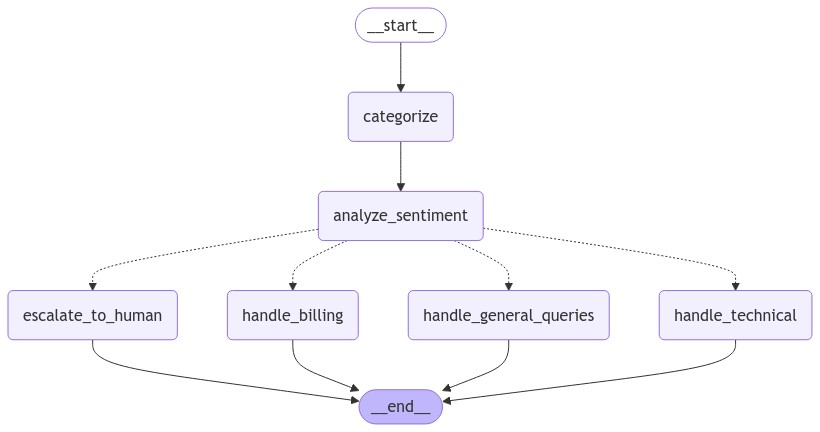

In [8]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
def run_customer_support(query: str):
    """Process a customer query through the LangGraph workflow.

    Args:
        query (str): The customer's query

    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = graph.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }

In [10]:
# escalate

query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: My internet connection keeps dropping. Can you help?
Category: content='**Technical** \n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]} id='run-1b8063ea-fae7-4ada-b610-23f3007caedf-0' usage_metadata={'input_tokens': 31, 'output_tokens': 3, 'total_tokens': 34}
Sentiment: content='Negative \n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'bloc

In [11]:
# handle_billing

query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


Query: where can i find my receipt?
Category: content='This query falls into the **Billing** category. \n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]} id='run-85a58150-e37b-45b1-8bfb-f1c82a6f767c-0' usage_metadata={'input_tokens': 28, 'output_tokens': 10, 'total_tokens': 38}
Sentiment: content='Neutral \n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIB

In [12]:
# just another helpter function
import textwrap
from IPython.display import display, Markdown

def to_markdown(text)-> Markdown:
    text : str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [23]:
to_markdown(result["category"].content)


> This query falls into the **Billing** category. 


In [24]:
to_markdown(result["sentiment"].content)


> Neutral 


In [25]:
to_markdown(result["response"].content)

> I understand you're looking for your receipt. To help me assist you better, could you please tell me:
> 
> * **Where did you make the purchase?** (e.g., online store, physical store, etc.)
> * **When did you make the purchase?** (e.g., date and approximate time)
> * **What was the purchase for?** (e.g., product, service, etc.)
> * **Have you checked your email inbox?** (Many online stores send receipts electronically)
> * **Do you have an account with the vendor?** (You may be able to access your receipt through your account)
> 
> Once I have this information, I can provide more specific guidance on where you can find your receipt. 
